In [1]:
import torch
import torch.nn as nn
from torchvision import transforms, models
from torch.utils.data import DataLoader
import pandas as pd
from PIL import Image
import os
from sklearn.metrics import classification_report, confusion_matrix
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt


In [2]:
device = torch.device("cpu")
print("Using device:", device)

Using device: cpu


In [3]:
eval_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [4]:
class EvalDataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, csv_path, transform=None):
        self.image_dir = Path(image_dir)
        self.transform = transform
        df = pd.read_csv(csv_path)
        self.filenames = df['id'].astype(str).values
        self.labels = df['label'].values

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        img_name = self.filenames[idx] + ".JPG"
        img_path = self.image_dir / img_name
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        label = int(self.labels[idx])
        return img, label, str(img_path)

In [5]:
eval_transforms = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
eval_dataset = EvalDataset("../data/test", "../data/test_labels.csv", eval_transforms)
eval_loader = DataLoader(eval_dataset, batch_size=1, shuffle=False)

In [6]:
df_labels = pd.read_csv("../data/test_labels.csv")
real_ids = df_labels[df_labels['label'] == 1]['id'].astype(str).values

reference_rgbs = []

for rid in real_ids:
    img_path = Path("../data/test") / f"{rid}.JPG"
    img = Image.open(img_path).convert("RGB")
    arr = np.array(img)
    reference_rgbs.append(arr.mean(axis=(0,1)))


In [7]:
reference_rgb = np.mean(reference_rgbs, axis=0)
tolerance = 5  
print("Reference RGB for real cards:", reference_rgb)

Reference RGB for real cards: [139.00920349 138.88483643 146.8567923 ]


In [8]:
def color_override(img_path, reference_rgb=reference_rgb, tolerance=tolerance):
    img = Image.open(img_path).convert("RGB")
    arr = np.array(img)
    img_mean = arr.mean(axis=(0,1))
    diff = np.abs(img_mean - reference_rgb)
    if np.any(diff > tolerance):
        return 0  
    else:
        return None

In [9]:
model = torch.load("../models/best_model.pth", map_location=device, weights_only=False)
model.eval()
print("Loaded model")

Loaded model


In [10]:
y_true, y_pred, paths = [], [], []
img_names_list = []

In [11]:
model.eval()
with torch.no_grad():
    for images, labels, img_names in eval_loader:
        img_path = img_names[0]  # batch_size=1
        override_label = color_override(img_path)
        
        if override_label is not None:
            pred_label = override_label
        else:
            images = images.to(device)
            outputs = model(images)
            probs = torch.sigmoid(outputs)
            pred_label = int((probs >= 0.5).cpu().numpy()[0])
        
        y_true.append(labels.item())
        y_pred.append(pred_label)
        img_names_list.append(img_path)

C:\Users\ernes\AppData\Local\Temp\ipykernel_1696\3304150438.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_label = int((probs >= 0.5).cpu().numpy()[0])


,image,true_label,pred_label
0,..\data\test\374.JPG,0,0
1,..\data\test\375.JPG,0,0
2,..\data\test\376.JPG,0,1
3,..\data\test\377.JPG,0,0
4,..\data\test\378.JPG,0,0
5,..\data\test\379.JPG,0,1
6,..\data\test\380.JPG,0,0
7,..\data\test\381.JPG,0,1
8,..\data\test\382.JPG,0,1
9,..\data\test\383.JPG,0,1



=== Classification Report ===

              precision    recall  f1-score   support

           0       0.62      0.64      0.63        28
           1       0.80      0.78      0.79        50

    accuracy                           0.73        78
   macro avg       0.71      0.71      0.71        78
weighted avg       0.73      0.73      0.73        78



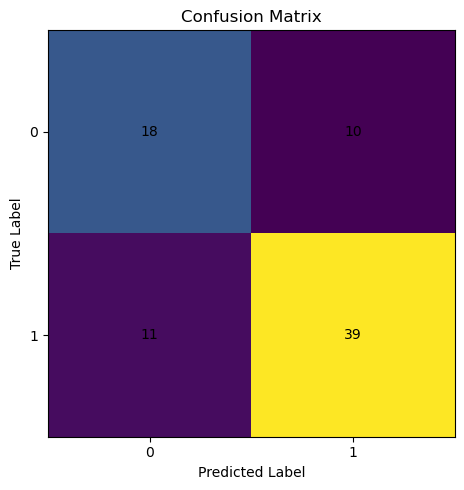

In [13]:
results = pd.DataFrame({
    "image": img_names_list,
    "true_label": y_true,
    "pred_label": y_pred
})

display(results.head(10))  # preview top 10
print("\n=== Classification Report ===\n")
print(classification_report(y_true, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
labels = sorted(list(set(y_true) | set(y_pred)))

fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(cm)

# Titles and labels
ax.set_title("Confusion Matrix")
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")

# Tick labels
ax.set_xticks(range(len(labels)))
ax.set_yticks(range(len(labels)))
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)

# Write values in cells
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha="center", va="center")

plt.tight_layout()
plt.show()